# Assignment 3 : "Word Vectors and Classification"
Due: Monday 2pm, Feburary 1, 2021, via Moodle

### Submission guidelines

- Solutions need to be uploaded as a single Jupyter notebook. You will find many provided codes in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do *not* hand in a separate file for it.
- Download the .zip file containing the dataset but do *not* upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the names of
all team members are given in the notebook.

--------

## Task 1: F.R.I.E.N.D.S and  Word2Vec ( 3+ 2+ 3 = 8 points) 

Friends is an American television sitcom, created by David Crane and Marta Kauffman. In this assignment we will use the transcripts from the show to train a Word2Vec model using the Gensim library.

### Subtask 1: Pre-processing 
We start by loading and cleaning the data. Download the dataset for this assignment and load the `friends_quotes.csv` using pandas. The dataset is from Kaggle (https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that could determine which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains the line from the movie and `author` is the one who spoke it. Since these are the only two columns we need, we remove the rest and only keep these two. 

In [36]:
import re  
import pandas as pd  
from collections import defaultdict  
import spacy 
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [37]:
df = pd.read_csv("friends_quotes.csv")### Load the data #### 
### filter out columns ### 
df = df[['author','quote']]
df.head()

,author,quote
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hum..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."


Fortunately, there is no missing data, so we do not need to worry about that. 

In [38]:
df.isnull().sum() # check for missing data

author    0
quote     0
dtype: int64

use SpaCy similar to assignment 2 to pre-process the text, perform the following steps: 
- lowercase the words 
- remove the stopwords and single characters
- use regex to remove non-alphabetic characters (anything that is not a number or alphabet including punctuations), in other words only keep "a" to "z" and digits. 
- remove lines that have less than 3 words, since they cannot contribute much to the training process.

Please do not add additional steps on your own or additional cleaning, we want to create comparable results. 

In [39]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS # only use these stop words, do not add your own! 
df["quote"] = df['quote'].apply(lambda x: re.sub("[/']", '',re.sub("[^A-Za-z\d']+", ' ', str(x))).lower())# lowercase and remove non-alphabetic characters
quotes =[] # to save all the lines 
for quote in df['quote'].to_list():
    tmp_token_list = []
    for token in nlp(quote):
        if token.text not in stopwords and len(token.text)>1:  # remove stopwords and single characters
            tmp_token_list.append(token.text)
    if len(tmp_token_list)>=3:  # remove lines that have less than 3 words
        quotes.append(" ".join(tmp_token_list))
### Your Code ### 


The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, to keep the computation time-limited and choose the most important words.

In [40]:
from gensim.models.phrases import Phrases, Phraser
sent = [quote.split() for quote in quotes]#list of all words# 
phrases = Phrases(sent, min_count=10)#define the phraser for bi-gram creation# 
new_lines = [phrases[line] for line in sent]#transform the lines# 

# ### find the top words for the vocabulary###

from gensim.corpora import Dictionary
vocab = Dictionary(new_lines).filter_extremes(no_below=0, no_above=1, keep_n=15000)

# vocab=###top words ###


INFO - 19:39:13: collecting all words and their counts
INFO - 19:39:13: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:39:13: PROGRESS: at sentence #10000, processed 73357 words and 54561 word types
INFO - 19:39:13: PROGRESS: at sentence #20000, processed 148180 words and 96583 word types
INFO - 19:39:13: PROGRESS: at sentence #30000, processed 221990 words and 133455 word types
INFO - 19:39:13: collected 161336 word types from a corpus of 278076 words (unigram + bigrams) and 37724 sentences
INFO - 19:39:13: using 161336 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 19:39:15: adding document #0 to Dictionary(0 unique tokens: [])
INFO - 19:39:15: adding document #10000 to Dictionary(8671 unique tokens: ['guy', 'tell', 'work', 'cmon', 'going']...)
INFO - 19:39:15: adding document #20000 to Dictionary(11791 unique tokens: ['guy', 'tell', 'work', 'cmon', 'going']...)
INFO - 19:39:15: adding document #30000 to Dicti

In [41]:
print(new_lines[0:10])

[['tell', 'guy', 'work'], ['cmon', 'going', 'guy', 'got_ta', 'wrong'], ['right', 'joey', 'nice', 'hump', 'hump', 'hairpiece'], ['wait', 'eat', 'chalk'], ['cause', 'nt', 'want', 'went', 'carl', 'oh'], ['okay', 'everybody', 'relax', 'date', 'people', 'going', 'dinner', 'having_sex'], ['sounds_like', 'date'], ['alright', 'high_school', 'standing', 'middle', 'cafeteria', 'realize', 'totally', 'naked'], ['oh', 'yeah', 'dream'], ['look', 'realize', 'phone']]


### Subtask 2: Training The Model


Use Gensim the implementation of Word2Vec to train a model on the scripts. The training can be divided into 3 stages:


1) Set up your model with parameters, define your parameters in such a way that the following conditions are satisfied:
 - ignores all words that have a total absolute frequency less than 2.
 - dimensions of the embeddings: 100 
 - initial learning rate of 0.03 
 - 20 negative samples 
 - window size 3 
 - learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps to avoid jumping over the local minima. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
 - set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
 - set the hashfunction of the word2vec to the given function.
 - train on a single worker to make sure you get the same result as ours.

In [42]:
from gensim.models import Word2Vec
def hash(astring):
    return ord(astring[0])

In [43]:
# num_workers = 1
# num_negative = 20
# num_features = 100
# min_word_count = 2
# window_size = 3
# subsampling = 6e-5
# alpha = 0.03
# min_alpha= 0.0001
# hashfunc = hash
# epochs = 100


w2v = Word2Vec(
    workers = 1,
    negative = 20,
    size = 100,
    min_count = 2,
    window = 3,
    sample = 6e-5,
    alpha = 0.03,
    min_alpha = 0.0001,
    hashfxn = hash,
    iter = 100
)### your code ### 

2) before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them.
If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus. Use the `build_vocab` function to process the data.

In [44]:
w2v.build_vocab(new_lines)### your code ### 

INFO - 19:39:16: collecting all words and their counts
INFO - 19:39:16: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:39:16: PROGRESS: at sentence #10000, processed 70495 words, keeping 8671 word types
INFO - 19:39:16: PROGRESS: at sentence #20000, processed 142215 words, keeping 11791 word types
INFO - 19:39:16: PROGRESS: at sentence #30000, processed 213077 words, keeping 13997 word types
INFO - 19:39:16: collected 15966 word types from a corpus of 267015 raw words and 37724 sentences
INFO - 19:39:16: Loading a fresh vocabulary
INFO - 19:39:16: effective_min_count=2 retains 9336 unique words (58% of original 15966, drops 6630)
INFO - 19:39:16: effective_min_count=2 leaves 260385 word corpus (97% of original 267015, drops 6630)
INFO - 19:39:16: deleting the raw counts dictionary of 15966 items
INFO - 19:39:16: sample=6e-05 downsamples 961 most-common words
INFO - 19:39:16: downsampling leaves estimated 121454 word corpus (46.6% of prior 260385)
INFO - 19:

3) Finally, we get to train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis. 

In [45]:
w2v.train(new_lines, total_examples=w2v.corpus_count, epochs=w2v.epochs)
w2v.init_sims()###your code ### 

INFO - 19:39:18: training model with 1 workers on 9336 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3
INFO - 19:39:18: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:18: EPOCH - 1 : training on 267015 raw words (121811 effective words) took 0.7s, 172816 effective words/s
INFO - 19:39:19: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:19: EPOCH - 2 : training on 267015 raw words (121294 effective words) took 0.6s, 192542 effective words/s
INFO - 19:39:20: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:20: EPOCH - 3 : training on 267015 raw words (121625 effective words) took 0.6s, 196369 effective words/s
INFO - 19:39:20: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:20: EPOCH - 4 : training on 267015 raw words (121648 effective words) took 0.6s, 203317 effective words/s
INFO - 19:39:21: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:21

INFO - 19:39:44: EPOCH - 42 : training on 267015 raw words (121305 effective words) took 0.6s, 200989 effective words/s
INFO - 19:39:44: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:44: EPOCH - 43 : training on 267015 raw words (121286 effective words) took 0.6s, 200224 effective words/s
INFO - 19:39:45: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:45: EPOCH - 44 : training on 267015 raw words (121952 effective words) took 0.6s, 199776 effective words/s
INFO - 19:39:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:46: EPOCH - 45 : training on 267015 raw words (121404 effective words) took 0.6s, 207687 effective words/s
INFO - 19:39:46: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:46: EPOCH - 46 : training on 267015 raw words (121190 effective words) took 0.6s, 199914 effective words/s
INFO - 19:39:47: worker thread finished; awaiting finish of 0 more threads
INFO - 19:39:47: EPOCH - 

INFO - 19:40:10: worker thread finished; awaiting finish of 0 more threads
INFO - 19:40:10: EPOCH - 85 : training on 267015 raw words (121742 effective words) took 0.6s, 206422 effective words/s
INFO - 19:40:10: worker thread finished; awaiting finish of 0 more threads
INFO - 19:40:10: EPOCH - 86 : training on 267015 raw words (121674 effective words) took 0.6s, 189775 effective words/s
INFO - 19:40:11: worker thread finished; awaiting finish of 0 more threads
INFO - 19:40:11: EPOCH - 87 : training on 267015 raw words (121488 effective words) took 0.6s, 192616 effective words/s
INFO - 19:40:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:40:12: EPOCH - 88 : training on 267015 raw words (121399 effective words) took 0.6s, 199631 effective words/s
INFO - 19:40:12: worker thread finished; awaiting finish of 0 more threads
INFO - 19:40:12: EPOCH - 89 : training on 267015 raw words (121518 effective words) took 0.6s, 190711 effective words/s
INFO - 19:40:13: worker t

### Subtask 3: Exploring the Model


As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset: 

We look for most similar words to the famous coffee shop where most of the episodes took place, namely `central_perk` and also one of the characters `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.



In [46]:
###your code### 
w2v.wv.most_similar("joey")

[('chandler', 0.8689682483673096),
 ('monica', 0.7192718982696533),
 ('looks', 0.7176671028137207),
 ('rachel', 0.7164907455444336),
 ('sees', 0.7001265287399292),
 ('tighter', 0.6866521239280701),
 ('tightly', 0.6843657493591309),
 ('phoebe', 0.6841847896575928),
 ('sips', 0.682151198387146),
 ('turns', 0.6685620546340942)]

In [47]:
###your code### 
w2v.wv.most_similar("central_perk")

[('conan', 0.6421816349029541),
 ('recliner', 0.6405543088912964),
 ('sitting_couch', 0.6292145252227783),
 ('laying', 0.5807685852050781),
 ('dejectedly', 0.5762094259262085),
 ('staging', 0.5736903548240662),
 ('scene', 0.5686823725700378),
 ('barr', 0.5503576993942261),
 ('baywatch', 0.5482350587844849),
 ('groundwork', 0.5413631200790405)]

In [48]:
# test


Look at the similarity of `mrs_green` to `rachel` (her mom) and `ross`  and `spaceship` (urelated). The first one should have a high and the second low score. Finally look at the similarity of `smelly_cat` ( a song from pheobe) and `song` the similarity should be high.

In [49]:
###your code### 
w2v.wv.similarity("mrs_green", "rachel")

0.6064009

In [50]:
###your code### 
w2v.wv.similarity("ross", "spaceship") 

-0.2465029

In [51]:
###your code### 
w2v.wv.similarity("smelly_cat", "song")

0.556052

We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar? 


In [52]:
character_names= ['joey', 'rachel', 'phoebe','monica', 'chandler']

In [53]:
w2v.wv.doesnt_match(character_names)### your code### 

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'joey'

Based on the analogies, which word is to `rachel` as `man` is to `women`? (print the top 3); you should get `chandler` and `monica` among the answers.

In [54]:
w2v.wv.most_similar(positive=["rachel", "man"], negative=["women"], topn=3)### your code### 

[('chandler', 0.6717850565910339),
 ('ross', 0.6703799962997437),
 ('monica', 0.6681786775588989)]

Finally, lets use t-SNE to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.manifold import TSNE

In [68]:
def tsneplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimilar words
    """
    embs = np.empty((0, 100), dtype='f')# to save all the embeddings
    word_labels = [word]
    color_list  = ['green']

   
    embs = np.append(embs, model.wv.__getitem__([word]), axis=0)# adds the vector of the query word
    
   
    close_words = model.wv.most_similar([word]) # gets list of most similar words
    # gets list of most dissimilar words (get the sorted list of all the words and their similarity and choose the bottom 10 )
    all_sims = sorted(model.wv.most_similar([word], topn=len(model.wv.vocab)-1), key=lambda tup: tup[1])
    far_words = all_sims[:10]
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]].reshape((1,100))  #get the vector 
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        embs = np.append(embs, wrd_vector, axis=0)
        
    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = model.wv[wrd_score[0]].reshape((1,100))  #get the vector 
        word_labels.append(wrd_score[0])
        color_list.append('red')
        embs = np.append(embs, wrd_vector, axis=0)
    
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=42, perplexity=15).fit_transform(embs)
    
    print(Y.shape)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

(21, 2)


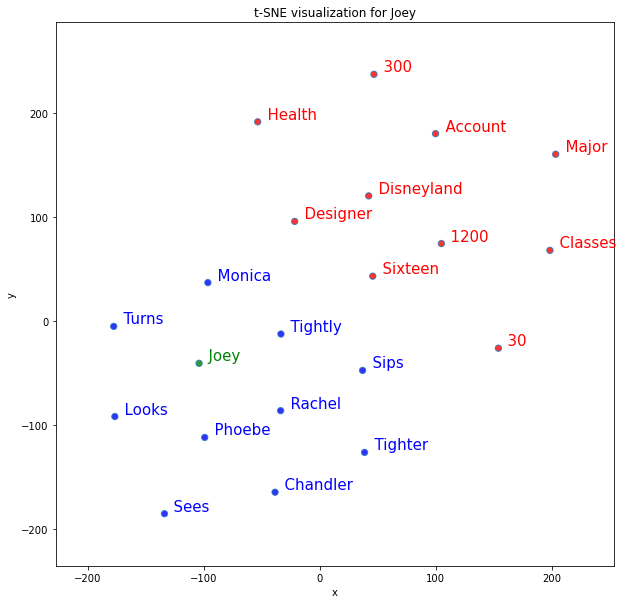

In [69]:
tsneplot(w2v, 'joey')

## Task 2: Multi-class Classification ( 1+ 3 + 2 = 6 points)
In this task, we aim to classify consumer finance complaints into 12 pre-defined classes. Note that this is not a multi-label task, and we assume that each new complaint is assigned to one and only one category. The data comes from https://www.data.gov/ (US government’s open data) and contains complaints that are published after the company responds, confirming a commercial relationship with the consumer, or after 15 days, whatever comes first.


### Sub Task 1: Data Exploration

Read the data to a pandas dataframe from `complaints.csv`; this is a rather large file of 206MB. Keep only the `Consumer complaint narrative` (input text) and `product`(labels). Remove the missing values, rename `Consumer complaint narrative` to `Narrative` for ease of use, and add a column encoding the product as an integer. This will represent your labels for classification and the mapping will be used later on. Create two dictionaries: one mapping the ids to products and one mapping products to their ids.

In [1]:
import pandas as pd
from io import StringIO
df = pd.read_csv("complaints.csv") ###read the file ####
df =  df[['Consumer complaint narrative','Product']] ###keep the columns you need ####
df.columns = ['Narrative', 'Product'] ###rename columns ####
df.head()

,Narrative,Product
0,NaN,Checking or savings account
1,"I was sold access to an event digitally, of wh...","Money transfer, virtual currency, or money ser..."
2,NaN,Vehicle loan or lease
3,NaN,Checking or savings account
4,NaN,Checking or savings account


In [17]:
df = df.dropna()### remove missing #### 
df['product_id'] = df.groupby('Product').ngroup()### integer ids for product ### 
### create the dictionary #### 
id2product = dict()
product2id = dict()
for _, row in df[['Product', 'product_id']].drop_duplicates().iterrows():
    product2id[row['Product']] = row['product_id']
    id2product[row['product_id']] = row['Product']
df.head()

,Narrative,Product,product_id
1,"I was sold access to an event digitally, of wh...","Money transfer, virtual currency, or money ser...",5
5,I LEASED MY CAR ON XX/XX/XXXX AND MADE PAYMENT...,Vehicle loan or lease,12
6,My original lender was XXXX XXXX XXXX ; this l...,Student loan,11
8,I was misled by XXXX XXXX and my degree did n...,Student loan,11
10,I purchased a vehicle 3 years ago. As of recen...,Vehicle loan or lease,12


Look at the class distribution of the products. It is always a good idea to look at the relative number of instances for each class before performing any classification task. Use the `plot` function from the dataframe to show the number of instances in each class in a histogram.

<Figure size 720x576 with 0 Axes>

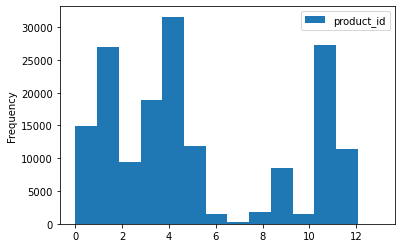

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = df.plot.hist(by='product_id', bins=14)
plt.show()

If you have done the exercise correctly you should observe a class imbalance with `credit reporting` having the most complaints. This can result in some difficulties for standard algorithms, making them biased towards the majority class and treating the minority classes as outliers and unimportant. One way to overcome this problem is by using **undersampling** or **oversampling**. However, this is beyond the scope of this assignment.

### Sub Task 2: Text Representation and Training the Classifier 
Before performing any classification we need to split our data into train and test sets. Use `sklearn` to save 20 percent of the data for the test and the rest for training. Make sure to input the index of the data frame to retrieve the indices of the test and train. 


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df['Narrative'].to_list(), df['product_id'].to_list(), df.index.to_list(), test_size=0.2)### your code ###

In [20]:
print(len(df['Narrative']))
print(len(X_train))
print(len(X_test))
print(len(X_test)/len(df['Narrative']))

165809
132647
33162
0.20000120620714196


To perform any sort of classification task, we first need to convert our raw text into some vector representation. Let's use the `TfidfVectorizer` from `sklearn` to convert the `narrative` column into TF-IDF vectors. When transforming the text keep the following in mind:
- use the logarithmic form for frequency
- remove accents (ASCII) 
- lowercase all characters 
- remove `English` stop words 
- ignore terms that have a document frequency strictly less than 10
- smooth IDF weights by adding one to document frequencies 
- output row should have unit L2 norm
- set the encoding to `Latin-1`
- extract both uni-grams and bi-grams 
- build a vocabulary that only considers the top 10.000 features
Keep in mind that the vectorizer should be trained **only** on the training data, and the test data should be transformed using the same model.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(
    sublinear_tf = True,  #  replace tf with 1 + log(tf).
    strip_accents = ascii,  # remove accent
    lowercase = True,
    stop_words = 'english',  # remove English stopwords
    min_df = 10,  # ignore terms whose idf < 10
    smooth_idf = True,
    norm = 'l2',
    encoding = 'Latin-1',
    ngram_range = (1, 2),
    max_features = 10000
)

    ###initlize the model ### 
X_train = tfidf.fit_transform(X_train)###transform text  ### 
X_train.shape # should be (132647, 10000) 

(132647, 10000)

After the data transformation, we attain the features and labels, to train the classifier. In our case, we use **Naive Bayes Classifier**. 
- split the features and labels into training and test set (set the random state to 42) 
- use `MultinomialNB` from sklearn to classify the data 

In [30]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()### fit the model to the data ### 
clf.fit(X_train, y_train)

MultinomialNB()

### Sub Task 3: Model Evaluation  

We evaluate our model using the held-out test data. We are going to look at the confusion matrix to show the performance of the model. 

[[1021 1547   37  221   87   80    0    0    0   19   12   26   11    0]
 [ 201 4783    2   80   77  253    0    0    0   17    0   23   12    0]
 [  41   46  516  122  230    5    0    0    0  192    0  160  570    0]
 [  64  152   32 2942  397   36    0    0    0    9    1   64    8    0]
 [  14   48   30  205 5835    3    0    0    0    6    0   74   35    0]
 [  18  484    2   52   17 1720    0    0    0   21    0   15    3    0]
 [  24   26    0   15    2  212    0    0    0    1    0    2    1    0]
 [   8   18    3    6    5    9    0    0    0    2    0   15    0    0]
 [  13   16   20    8   26    3    0    0    4  212    0   44    1    0]
 [  23  179   68   73  123   22    0    0    0  838    1  266  146    0]
 [  35   77    0  111    2   21    0    0    0    0   37    1    0    0]
 [  11   33   12   18  203    8    0    0    0   13    0 5172   33    0]
 [   6   57  141   44  151    0    0    0    0   56    0   94 1707    0]
 [   0    2    0    0    0    4    0    0    0    0

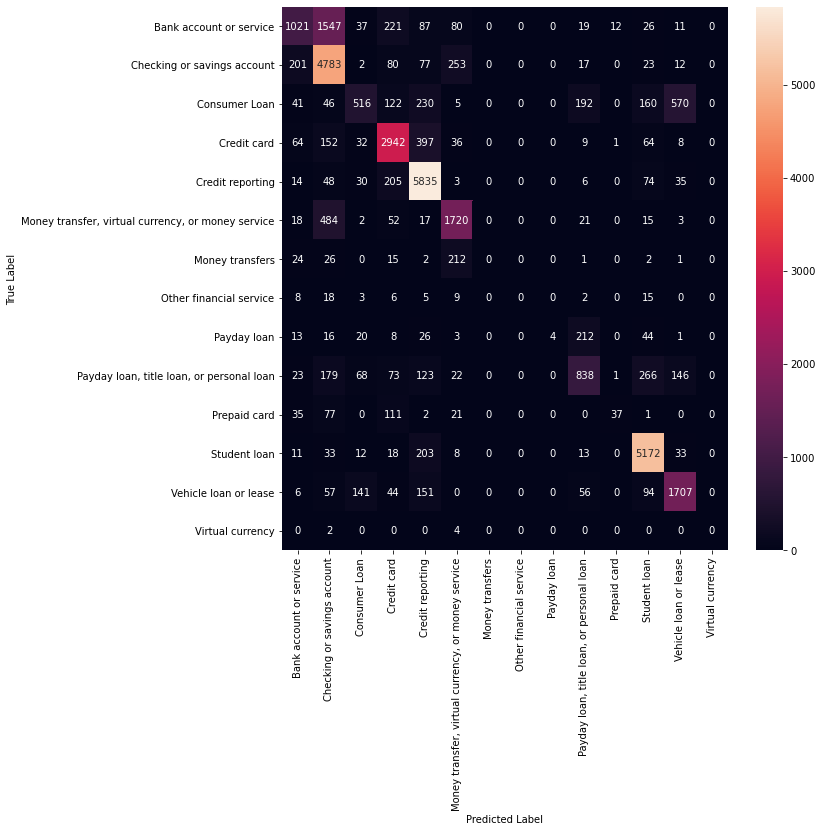

0.2589409565164948


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = clf.predict(tfidf.transform(X_test))### predict on the test set ### 
conf = confusion_matrix(y_test, y_pred, labels=[i for i in range(14)])### create the confusion matrix ### 
fig, ax = plt.subplots(figsize=(10,10))
print(conf)
# todo: x and y ticklabels
sns.heatmap(conf, annot=True, fmt='d',
            xticklabels=[id2product[i] for i in range(14)], ###products names from the dictionary ###,
            yticklabels=[id2product[i] for i in range(14)])### products names from the dictionary###)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
import numpy as np
def cal_err(true, pred):
    return np.sum((true-pred)!=0)/len(true)
print(cal_err(y_pred, y_test))

The majority of the predictions end up on the diagonal (predicted label = actual label). The diagonal shows the correct classified classes. However, there are several misclassifications, specifically `Checking or savings account` is often confused with `Bank account or service`. Let's take a look at why this happens. For this, we look at 5 misclassified examples.

In [ ]:
actual='Bank account or service'
predicted= 'Checking or savings account'
### print only the top 10 
df###choose the ones that have an actual label of Bank account or service and the predicted label of Checking or savings account ###)

As you can see, some of the misclassified complaints are complaints that are not easy to distinguish. 

## Task 3: Auto-Complete ( 2 + 5 + 4 = 11 Points ) 
Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]
By the end of this assignment, you will develop a simple prototype of such a system using n-gram language models. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word. 

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language models by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Sub Task 1: Load and Preprocess Data 
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where tweets are separated by `\n`

In [2]:
import math
import random
import numpy as np
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])


with open("twitter.txt", "r", encoding='UTF-8') as f:
    data = f.read()
print("First 500 characters of the data:")
display(data[0:500])
print("-------")

First 500 characters of the data:


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\nWords from a complete stranger! Made my birthday even better :)\nFirst Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\ni no! i ge"

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.) 
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required. Although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

In [27]:
sentences = data.split('\n')#split
# todo
# sentences = #remove spaces and drop empty sentences 
print(len(sentences))

47962


In [28]:
tokenized_corpus = [[token.text.lower() for token in nlp(sent)] for sent in sentences]# list of list of the tokens in a sentence 
##Your Code###   
print(len(tokenized_corpus))

47962


In [29]:
from random import Random
Random(4).shuffle(tokenized_corpus)

train = tokenized_corpus[0:int(0.8* len(tokenized_corpus))]
test = tokenized_corpus[int(0.8* len(tokenized_corpus)): len(tokenized_corpus)] ##Your Code###     

In [31]:
from collections import Counter
flatten_corpus = [token for token_list in train for token in token_list] ### Flatten the train corpus ### 
word_counts = Counter(flatten_corpus) ### count the number of each token ### 
print(len(word_counts))
vocab = [token for token, freq in word_counts.items() if freq>=2]

### keep only the ones with frequency bigger than 2 ### 
print(len(vocab)) ### should be 16930 ### 
train_replaced = []
test_replaced = []
for sentence in train:
    ### adjust the sentence to contain the word in the vocabulary and <unk> for the rest #### 
    new_sent = []
    for token in sentence:
        if token in vocab:
            new_sent.append(token)
        else:
            new_sent.append('<unk>')
    train_replaced.append(new_sent)
for sentence in test:
    new_sent = []
    for token in sentence:
        if token in vocab:
            new_sent.append(token)
        else:
            new_sent.append('<unk>')
    train_replaced.append(new_sent)

35102
14863


### Sub Task 2: N-gram Based Language Model: 
In this section, you will develop the n-grams language model. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_n)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word 't' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will: 
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
4. Create a probability matrix. 
The steps are detailed below. 

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n_gram counts.

In [ ]:
def n_grams_counts(corpus, n):
    """
    Count all n-grams in the corpus given the parameter n 
    
    data: List of lists of words (your tokenized corpus)
    n: n in the n-gram
    
    Returns: A dictionary that maps a tuple of n words to its frequency
    """
    start_token='<s>'
    end_token = '<e>'
    n_grams = defaultdict(int)
    for sentence in corpus: 
        sentence = ### add start and end token ###
        # convert list to tuple so it can be used a the key in the dictionary 
        sentence = tuple(sentence)
        
        ###iterate over the n-grams in the sentence, you can use the range() function, and increament the counts in the
        ## n_grams dictionary, where the key is the n_gram and the value is count 
    return n_grams

The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


In [ ]:
def probability(word, prev_n_gram, 
                         n_gram_cnts, n_plus1_gram_cnts, vocab_size):
    """
    Estimate the probabilities of a next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary
    
    Returns: A probability
    """
    k=1.0
    prev_n_gram = tuple(prev_n_gram)
    
    prev_n_gram_cnt =  # get the previous n-gram count from the dictionary 
    denominator = # denominator with the previous n-gram count and k-smoothing
    n_plus1_gram =  # add the current word to the n-gram 
    n_plus1_gram_cnt =  # get the current n-gram count using the dictionary
    numerator = #calculate the numerator with k-smoothing
    prob =
    
    return prob

Let's use the functions we have defined to calculate probabilities for all possible words.


In [ ]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary given the previous n-gram 
    prev_n_gram: previous n-gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cntsplus_current_gram_cnt: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    
    Returns: A dictionary mapping from next words to the probability.
    """
    prev_n_gram = tuple(prev_n_gram)
    
    vocab =  # add <e> <unk> to the vocabulary
    vocabulary_size = #compute the size 
    
    probabilities = {}
    for word in vocab:
        ### compute the probability 
    return probabilities

In [ ]:
# Predict the probability of the all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)

## Sub Task 3: Evaluation 

In this section we use the perplexity score to evaluate your model on the test set.
the perplexity score of the test set on an n-gram model, is denoted as follows: 

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.

Notice that we have already computed this probability. 

The higher the probabilities are, the lower the perplexity will be. 

In [ ]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary
    k: positive smoothing constant
    
    Returns: Perplexity score for a single sentence 
    """
    
    n =  # get the number 'n' in  n-gram  from n_gram_cnts  
    
    sentence =  # prepend <s> and append <e>
    sentence = tuple(sentence)
    N =# length of sentence 
    
   
    product_pi = 1.0 
    
    ### Compute the product of probabilites ###
    
    for t in range(n, N): 
        n_gram =# get the n-gram before the predicted word (n-gram before t )
        word =  # get the word to be predicted (position t)
        prob = probability(
        product_pi *= # Update the product of the probabilities
    
    perplexity = product_pi**(1/float(N)) # Take the Nth root of the product
    return perplexity

Use the function to find the perplexity of a bi-gram model on the first instance of training and test set.

In [ ]:
bigram_counts = ### your code ###
trigram_counts = ### your code ###

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}")# the preprexity for the train sample should be much lower 

Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [ ]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab , start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length > n 
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word
        
    Returns: (most likely next word,  probability) 
    """    
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts     
    previous_n_gram = previous_tokens[-n:] # get the last 'n' words as the previous n-gram from the input sentence

    
    probabs = # Estimate the probabilities for each word in the vocabulary
    
    probabs = 
    ### sort the probability for higher to lower and return the highest probability word,probability tuple
    #if start_with is specified then return the highest probability word that starts with that specific character 


Test your model based on the bi-gram model created on the training corpus.

In [ ]:
previous_tokens=['i','like']
start_with='g'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

In [ ]:
previous_tokens=['i','like','to']
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

In [ ]:
previous_tokens=["hello", "my", "name", "is"]
start_with='sa'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

## Task 4: Theoretical Questions ( 1 +1 +1 +1 + 1 = 5 Points) 


Please answer the following questions in the notebook cells using markdown, try to be percise and short. 

### Sub Task 1: What is the goal of Word2Veec? / What is a word embedding?

<<< your answer >>>

### Sub Task 2: For gradient descent, what advantage has a decaying learning rate?

<<< your answer >>>

### Sub Task 3: Why is it easier to maximize the log likelihood instead of the "normal" likelihood?

<<< your answer >>>

### Sub Task 4: Word2Vec trains a complete neural network. How do we extract word embeddings from this network?

<<< your answer >>>


### Sub Task 5: What advantages has fastText over Word2Vec? 

<<< your answer >>>
